# GROUP 4 Take home assessment
> Members
> - Teo Jia Qing
> - Pang Hong Yun
> - Wong Kwan Kit Jeriel
> - Wei Gangru 

### Imports

In [4]:
################################### imports ######################################
import datetime as dt
import math
import random
import time
import warnings
from datetime import timedelta
from multiprocessing import cpu_count

import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.arima.model as stats
import xgboost as xgb
import yfinance as yf
from dateutil.relativedelta import relativedelta
from keras.layers import LSTM, Activation, Bidirectional, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from pandas_datareader import data as pdr
from plotly.subplots import make_subplots
from pmdarima import auto_arima, plot_acf
from pmdarima.arima import ARIMA, ndiffs, nsdiffs
from scipy.cluster.hierarchy import fcluster  # AGNES
from scipy.cluster.hierarchy import dendrogram, linkage, ward
from sklearn import linear_model, metrics
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import \
    LinearDiscriminantAnalysis  # multi-class
from sklearn.ensemble import (AdaBoostClassifier, AdaBoostRegressor,
                              ExtraTreesClassifier, ExtraTreesRegressor,
                              GradientBoostingClassifier,
                              GradientBoostingRegressor,
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import (ElasticNet, Lasso, LinearRegression,
                                  LogisticRegression)
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, make_scorer,
                             mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     TimeSeriesSplit, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_acf
import pandas_ta as ta



np.set_printoptions(precision = 3)
plt.style.use("ggplot")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14



warnings.filterwarnings("ignore")




### Functions

In [5]:
################################### functions ######################################
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean( u[:period] ) 
    u = u.drop(u.index[:(period - 1)])
    d[d.index[period - 1]] = np.mean( d[:period] )
    d = d.drop(d.index[:(period - 1)])
    rs = u.ewm(com = period - 1, adjust = False).mean() / d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

def extract(TICKERS, start, end):
    def data(ticker):
        return pdr.DataReader(ticker, "yahoo", start, end)
    S = map(data, TICKERS)
    print(S)
    return pd.concat(S, keys=TICKERS, names=["Ticker", "Date"])

# ARIMA 
def get_auto_arima_pred(X_train,X_test,Y_train,Y_test):
    X_train_ARIMA = X_train
    X_test_ARIMA = X_test

    train_len = len(X_train_ARIMA)
    test_len = len(X_test_ARIMA)
    total_len = len(X)

    # USING PMDARIMA 
    # SARIMAX model 
    pmd_sarimax_model = auto_arima(y=Y_train,x=X_train_ARIMA,m=7)

    y_prediction = pmd_sarimax_model.predict(n_periods=test_len,X=X_test_ARIMA)

    y_prediction = pd.Series(y_prediction, index=Y_test.index)

    return y_prediction


# EDA

In [6]:
stock_data = pdr.DataReader("SPY", "yahoo","2003-11-01","2022-10-31")
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-10-31,105.739998,105.220001,105.400002,105.300003,25761600.0,72.903069
2003-11-03,106.610001,105.709999,105.750000,105.989998,37589300.0,73.380783
2003-11-04,106.269997,105.580002,105.989998,105.760002,31421600.0,73.221542
2003-11-05,105.970001,104.900002,105.489998,105.839996,33558800.0,73.276901
2003-11-06,106.440002,105.099998,105.599998,106.400002,28392300.0,73.664665
...,...,...,...,...,...,...
2022-10-25,385.250000,378.670013,378.790009,384.920013,78846300.0,384.920013
2022-10-26,387.579987,381.350006,381.619995,382.019989,104087300.0,382.019989
2022-10-27,385.000000,379.329987,383.070007,379.980011,81971800.0,379.980011


In [7]:
return_period = 5
SPY = stock_data[["Adj Close"]]
SPY["Returns"] = np.log(SPY["Adj Close"]).diff(return_period).shift(-return_period)
SPY["NEW"] = SPY["Adj Close"]*(np.exp(SPY["Returns"]))
SPY["Direction"] = SPY["Returns"].apply(lambda x : 1 if x >=0 else 0)
SPY.head(10)

,Adj Close,Returns,NEW,Direction
Date,,,,
2003-10-31,72.903069,0.002940,73.117699,1
2003-11-03,73.380783,-0.007672,72.819984,0
2003-11-04,73.221542,-0.005784,72.799232,0
2003-11-05,73.276901,0.004619,73.616142,1
2003-11-06,73.664665,-0.000376,73.636978,0
2003-11-07,73.117699,-0.001421,73.013847,0
2003-11-10,72.819984,-0.002379,72.646919,0
2003-11-11,72.799232,-0.012537,71.892242,0
2003-11-12,73.616142,-0.015257,72.501534,0


# Preparing X variables

In [8]:
X1 = pd.concat([np.log(stock_data.loc[:, ("Adj Close")]).ewm(span=i, adjust=False, min_periods=i).mean()
               for i in [10, 30, 60]], axis=1)
X1.columns = ["EWM_10", "EWM_30", "EWM_60"]

X2 = pd.concat([np.log(stock_data.loc[:, ("Adj Close")]).ewm(span=i, adjust=False, min_periods=i).std()
               for i in [10, 30, 60]], axis=1)
X2.columns = ["EW_VOL_10", "EW_VOL_30", "EW_VOL_60"]

X3 = pd.concat([np.log(stock_data.loc[:, ("Adj Close")]).rolling(window=i).mean() for i in [
    21, 63, 126, 252
]], axis=1
).dropna()
X3.columns = ["SMA_21", "SMA_63", "SMA_126", "SMA_252"]

X4 = pd.concat(
    [np.log(stock_data.loc[:, ("Adj Close")]).diff(i)
     for i in [return_period, return_period * 3, return_period * 6, return_period * 12]],
    axis=1).dropna()
X4.columns = ["SPY_5D", "SPY_15D", "SPY_30D", "SPY_60D"]

X = pd.concat([X1, X2, X3, X4], axis=1)

X["RSI_10"] = RSI(stock_data["Adj Close"], 10)
X["RSI_30"] = RSI(stock_data["Adj Close"], 30)
X["RSI_60"] = RSI(stock_data["Adj Close"], 60)
X["RSI_200"] = RSI(stock_data["Adj Close"], 200)

X["EWM_CROSSOVER_10_30"] = np.where(X["EWM_10"] < X["EWM_30"], -1, 1)
X["EWM_CROSSOVER_10_60"] = np.where(X["EWM_10"] < X["EWM_60"], -1, 1)
X["EWM_CROSSOVER_30_60"] = np.where(X["EWM_30"] < X["EWM_60"], -1, 1)

X["EW_VOL_CROSSOVER_10_30"] = np.where(X["EW_VOL_10"] < X["EW_VOL_30"], 1, -1)
X["EW_VOL_CROSSOVER_10_60"] = np.where(X["EW_VOL_10"] < X["EW_VOL_60"], 1, -1)
X["EW_VOL_CROSSOVER_30_60"] = np.where(X["EW_VOL_30"] < X["EW_VOL_60"], 1, -1)

X["SMA_CROSSOVER_21_63"] = np.where(X["SMA_21"] < X["SMA_63"], -1, 1)
X["SMA_CROSSOVER_21_126"] = np.where(X["SMA_21"] < X["SMA_126"], -1, 1)
X["SMA_CROSSOVER_21_252"] = np.where(X["SMA_21"] < X["SMA_252"], -1, 1)
X["SMA_CROSSOVER_63_126"] = np.where(X["SMA_63"] < X["SMA_126"], -1, 1)
X["SMA_CROSSOVER_63_252"] = np.where(X["SMA_63"] < X["SMA_252"], -1, 1)
X["SMA_CROSSOVER_126_252"] = np.where(X["SMA_126"] < X["SMA_252"], -1, 1)

data = pd.concat([SPY, X], axis=1).dropna().iloc[::return_period, :]
data


,Adj Close,Returns,NEW,Direction,EWM_10,EWM_30,EWM_60,EW_VOL_10,EW_VOL_30,EW_VOL_60,...,EWM_CROSSOVER_30_60,EW_VOL_CROSSOVER_10_30,EW_VOL_CROSSOVER_10_60,EW_VOL_CROSSOVER_30_60,SMA_CROSSOVER_21_63,SMA_CROSSOVER_21_126,SMA_CROSSOVER_21_252,SMA_CROSSOVER_63_126,SMA_CROSSOVER_63_252,SMA_CROSSOVER_126_252
Date,,,,,,,,,,,,,,,,,,,,,
2004-11-01,79.855545,0.031223,82.388176,1,4.369235,4.366234,4.363473,0.012120,0.012628,0.014844,...,1,1,1,1,1,1,1,-1,1,1
2004-11-08,82.388176,0.016698,83.775421,1,4.391256,4.376375,4.369306,0.021304,0.020628,0.020013,...,1,-1,-1,-1,1,1,1,1,1,1
2004-11-15,83.775421,-0.006337,83.246216,0,4.409694,4.388456,4.376878,0.020613,0.026525,0.025879,...,1,1,1,-1,1,1,1,1,1,1
2004-11-22,83.246216,-0.000763,83.182724,0,4.417873,4.398213,4.383948,0.014512,0.027529,0.029150,...,1,1,1,1,1,1,1,1,1,1
2004-11-30,83.182724,0.001780,83.330902,1,4.420901,4.405223,4.389944,0.009288,0.025937,0.030357,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,367.950012,-0.029707,357.179993,0,5.947900,5.975732,5.985513,0.031959,0.039342,0.043130,...,-1,1,1,1,-1,-1,-1,-1,-1,-1
2022-09-30,357.179993,0.015584,362.790009,1,5.913889,5.952985,5.971741,0.035066,0.050037,0.051576,...,-1,1,1,1,-1,-1,-1,-1,-1,-1
2022-10-07,362.790009,-0.014325,357.630005,0,5.915030,5.942782,5.963378,0.025406,0.046292,0.051810,...,-1,1,1,1,-1,-1,-1,-1,-1,-1


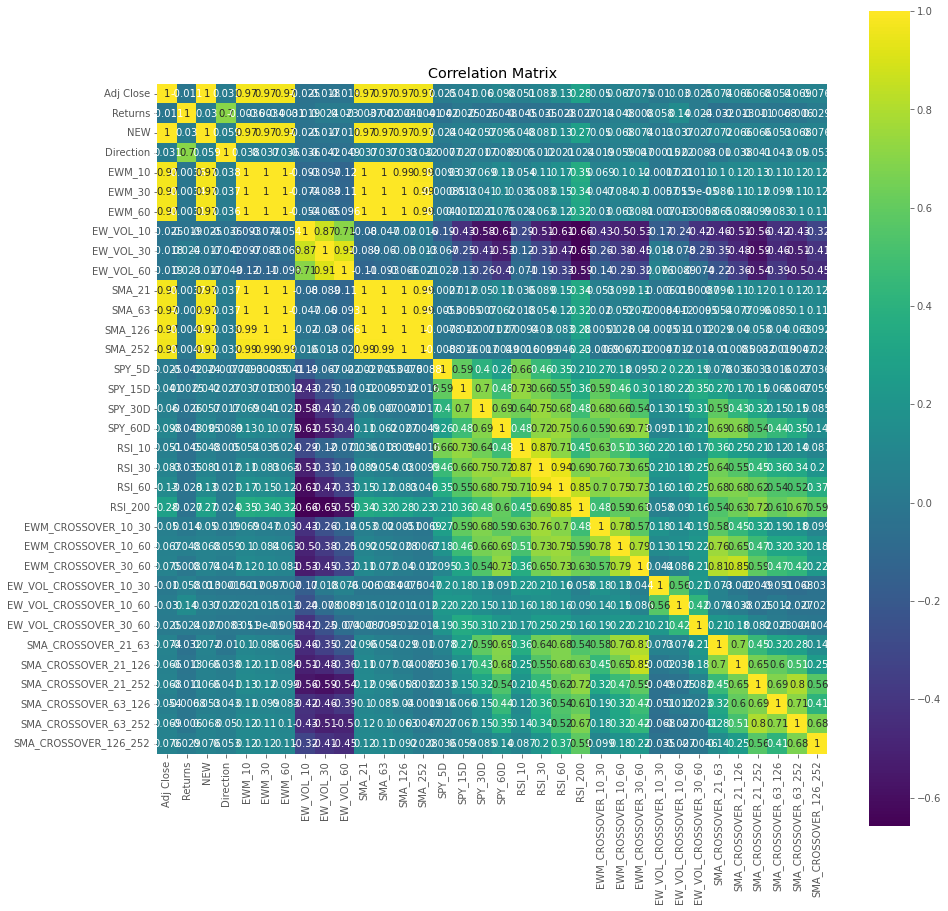

In [8]:
# Correlation matrix
correlation = data.corr()

plt.figure(figsize=(15,15))
plt.title("Correlation Matrix")

sns.heatmap(correlation, 
            vmax = 1, 
            square = True,
            annot = True,
            cmap = "viridis")

# Train Test Split

In [9]:
Y = data["Direction"]
X = data.loc[:, X.columns]

validation_size = 0.3

X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = validation_size, 
                                                    shuffle=False)

# [1] Modeling and strategy

## [1.1] Model 1: Machine Learning Models

In [10]:
# test options for classification
num_folds = 10
seed = 7
scoring = "precision"

In [11]:
# spot check the algorithms

models = []

models.append(("LR", LogisticRegression(n_jobs = -1)
              )
             )

models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))

#Neural Network
models.append(("NN", MLPClassifier()))

# Ensable Models 

# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
models.append(("XGB", xgb.XGBClassifier()))
# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs = -1)))
             


In [12]:
results = []

names = []

for name, model in models:
    kfold = KFold(n_splits = num_folds, 
                  random_state = seed, 
                  shuffle = True)
    cv_results = cross_val_score(model, 
                                 X_train, 
                                 Y_train, 
                                 cv = kfold, 
                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/Users/teojiaqing/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/teojiaqing/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

LR: 0.577035 (0.059813)
LDA: 0.575077 (0.087957)
KNN: 0.619662 (0.085142)
CART: 0.601728 (0.055241)
NB: 0.578984 (0.064437)
NN: 0.580889 (0.058998)
AB: 0.605079 (0.075109)
GBM: 0.601720 (0.064669)
XGB: 0.602602 (0.068478)
RF: 0.600353 (0.065453)


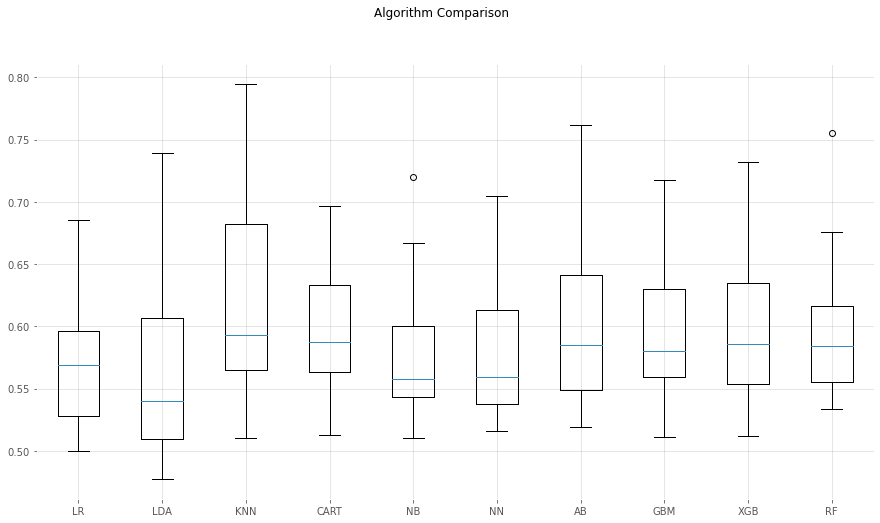

In [13]:
fig = plt.figure()
fig.suptitle("Algorithm Comparison")

ax = fig.add_subplot(111)

plt.boxplot(results)

ax.set_xticklabels(names)

fig.set_size_inches(15,8)

plt.show()

In [14]:
XG=xgb.XGBClassifier(colsample_bytree=0.6, gamma= 4, max_depth= 5, subsample= 0.5).fit(X_train,Y_train)
confusion_matrix(Y_test,XG.predict(X_test))

array([[ 27,  70],
       [ 31, 144]])

In [15]:
GB = GradientBoostingClassifier(n_estimators=60,max_depth=13,min_samples_leaf=40,max_features=15,random_state=1030).fit(X_train,Y_train)
confusion_matrix(Y_test,GB.predict(X_test))

array([[ 30,  67],
       [ 37, 138]])

In [16]:
KNN=KNeighborsClassifier(n_neighbors=3).fit(X_train,Y_train)
confusion_matrix(Y_test,KNN.predict(X_test))

array([[ 42,  55],
       [ 70, 105]])

In [17]:
GB=GradientBoostingClassifier(n_estimators=60,max_depth=13,min_samples_leaf=40,max_features=15,random_state=1030).fit(X_train,Y_train)
confusion_matrix(Y_test,GB.predict(X_test))

array([[ 30,  67],
       [ 37, 138]])

In [18]:
gb = pd.DataFrame(GB.predict(X_test),columns=["GB"])
knn = pd.DataFrame(KNN.predict(X_test),columns=["KNN"])
xg = pd.DataFrame(XG.predict(X_test),columns=["XGB"])

In [19]:
results = pd.DataFrame(Y_test).reset_index()
results["GB"] = gb["GB"]
results["KNN"] = knn["KNN"]
results["XGB"] = xg["XGB"]
results["Ensembled"] = results.apply(lambda x : x["GB"]+x["KNN"]+x["XGB"],axis=1)
results["Ensembled_pred"] = np.where(results["Ensembled"]>1,1,0)
confusion_matrix(results["Direction"],results["Ensembled_pred"])

array([[ 31,  66],
       [ 36, 139]])

In [20]:
confusion_matrix(results["Direction"],results["GB"])

array([[ 30,  67],
       [ 37, 138]])

In [21]:
confusion_matrix(results["Direction"],results["KNN"])

array([[ 42,  55],
       [ 70, 105]])

In [22]:
confusion_matrix(results["Direction"],results["XGB"])

array([[ 27,  70],
       [ 31, 144]])

In [23]:
results = results.replace(0,-1)
results.set_index("Date",inplace=True)

In [24]:
merged = pd.merge(results,SPY,left_on="Date",right_on="Date",how="left")
merged = merged.dropna()
merged.head()

,Direction_x,GB,KNN,XGB,Ensembled,Ensembled_pred,Adj Close,Returns,NEW,Direction_y
Date,,,,,,,,,,
2017-06-06,1,1,-1,1,2,1,221.003876,0.005494,222.221481,1
2017-06-13,-1,1,1,-1,2,1,222.221481,-0.001452,221.898987,0
2017-06-20,-1,-1,-1,1,1,-1,221.898987,-0.006937,220.364944,0
2017-06-27,1,-1,1,1,2,1,220.364944,0.005949,221.679886,1
2017-07-05,1,-1,-1,-1,-1,-1,221.679886,0.005095,222.812149,1


In [25]:
merged["GB_Strategy"]=merged["GB"]*merged["Returns"]
merged["KNN_Strategy"]=merged["KNN"]*merged["Returns"]
merged["XGB_Strategy"]=merged["XGB"]*merged["Returns"]
merged["ENSEMBLED_Strategy"]=merged["Ensembled_pred"]*merged["Returns"]
merged[["Returns","GB_Strategy","KNN_Strategy","XGB_Strategy","ENSEMBLED_Strategy"]].cumsum().apply(np.exp)[-1:]

,Returns,GB_Strategy,KNN_Strategy,XGB_Strategy,ENSEMBLED_Strategy
Date,,,,,
2022-10-21,1.760241,5.259461,1.381729,4.65184,5.525939


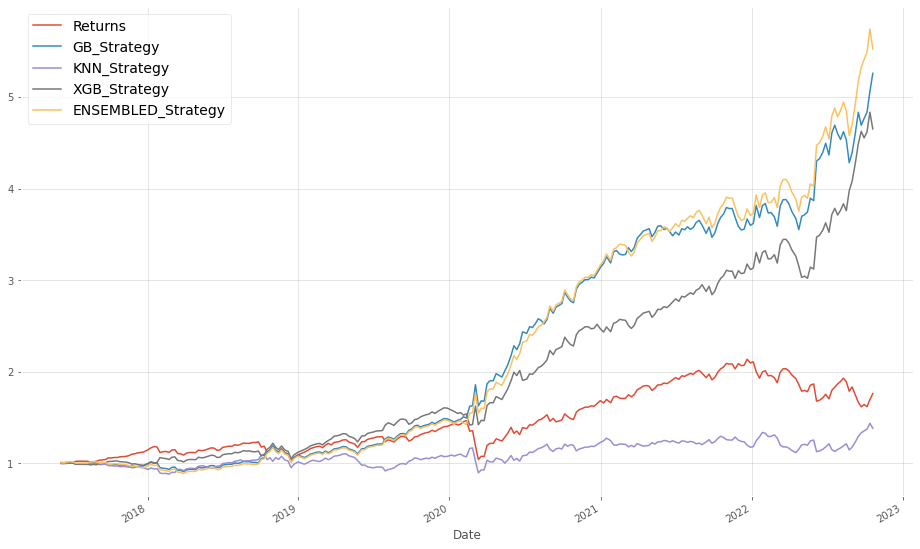

In [26]:
merged[["Returns","GB_Strategy","KNN_Strategy","XGB_Strategy","ENSEMBLED_Strategy"]].cumsum().apply(np.exp).plot(figsize=(16,10))

In [27]:
merged[["CUMULATIVE_RETURNS_SPY","CUMULATIVE_RETURNS_GB","CUMULATIVE_RETURNS_KNN","CUMULATIVE_RETURNS_XGB","CUMULATIVE_RETURNS_ENSEMBLED"]] = merged[["Returns","GB_Strategy","KNN_Strategy","XGB_Strategy","ENSEMBLED_Strategy"]].cumsum().apply(np.exp)

## [1.2] Model 2: LSTM

In [28]:
# X_LSTM = pd.concat([X1, X2, X3, X4], axis = 1)
# data = pd.concat([SPY, X_LSTM], axis = 1).dropna().iloc[ : :return_period, :]
Y_LSTM = data["Returns"]
# X_LSTM = data

X_train, X_test, Y_LSTM_train, Y_LSTM_test = train_test_split(X, 
                                                              Y_LSTM, 
                                                              test_size = validation_size, 
                                                              shuffle=False)

In [29]:
# LSTM 
# TIME SERIES NETWORK BUILDING
def build_LSTM(X_train_LSTM, 
            #    neurons=12, 
            #    learn_rate=0.01, 
            #    momentum=0
               ):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape= (X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    return model

In [30]:
# walk forward validation 
seq_len = 2

Y_train_LSTM, Y_test_LSTM = np.array(Y_LSTM_train)[seq_len-1:], np.array(Y_LSTM_test)
X_train_LSTM = np.zeros((X_train.shape[0] + 1 - seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))

for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0] + i + 1 - seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0] + i - 1:X.shape[0] + i + 1 - seq_len, :]

In [31]:
data

,Adj Close,Returns,NEW,Direction,EWM_10,EWM_30,EWM_60,EW_VOL_10,EW_VOL_30,EW_VOL_60,...,EWM_CROSSOVER_30_60,EW_VOL_CROSSOVER_10_30,EW_VOL_CROSSOVER_10_60,EW_VOL_CROSSOVER_30_60,SMA_CROSSOVER_21_63,SMA_CROSSOVER_21_126,SMA_CROSSOVER_21_252,SMA_CROSSOVER_63_126,SMA_CROSSOVER_63_252,SMA_CROSSOVER_126_252
Date,,,,,,,,,,,,,,,,,,,,,
2004-11-01,79.855583,0.031222,82.388184,1,4.369236,4.366234,4.363473,0.012120,0.012628,0.014844,...,1,1,1,1,1,1,1,-1,1,1
2004-11-08,82.388184,0.016698,83.775414,1,4.391256,4.376375,4.369306,0.021304,0.020627,0.020013,...,1,-1,-1,-1,1,1,1,1,1,1
2004-11-15,83.775414,-0.006337,83.246216,0,4.409694,4.388456,4.376879,0.020612,0.026525,0.025879,...,1,1,1,-1,1,1,1,1,1,1
2004-11-22,83.246216,-0.000763,83.182724,0,4.417873,4.398213,4.383948,0.014511,0.027529,0.029150,...,1,1,1,1,1,1,1,1,1,1
2004-11-30,83.182724,0.001779,83.330856,1,4.420901,4.405223,4.389944,0.009288,0.025937,0.030357,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,367.950012,-0.029707,357.179993,0,5.947900,5.975732,5.985513,0.031959,0.039342,0.043130,...,-1,1,1,1,-1,-1,-1,-1,-1,-1
2022-09-30,357.179993,0.015584,362.790009,1,5.913889,5.952985,5.971741,0.035066,0.050037,0.051576,...,-1,1,1,1,-1,-1,-1,-1,-1,-1
2022-10-07,362.790009,-0.014325,357.630005,0,5.915030,5.942782,5.963378,0.025406,0.046292,0.051810,...,-1,1,1,1,-1,-1,-1,-1,-1,-1


In [32]:
"""
This means that we will use 633 seqences to represent 2 days of price changes in training 
to predict for 272 days in the future 
30 here is the number of features we have for everyday 
"""
X_train_LSTM.shape, X_test_LSTM.shape

((633, 2, 30), (272, 2, 30))

In [33]:
LSTM_Model = build_LSTM(X_train_LSTM)

LSTM_Model_Fit = LSTM_Model.fit(X_train_LSTM,
                                Y_train_LSTM,
                                validation_data=(X_test_LSTM, Y_test_LSTM),
                                epochs=330,
                                verbose=0,
                                shuffle=False,
                                batch_size=72)

Predicted = LSTM_Model.predict(X_test_LSTM)

2022-11-18 17:55:28.506958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9/9 [==============================] - 0s 3ms/step


In [34]:
yhat_lstm = pd.DataFrame(Predicted.tolist(), columns=['yhat'], index=Y_test.index)
lstm_results_df = pd.concat([Y_test, yhat_lstm], axis = 1)

# get the price back and determing strategy to get Pnl and drawdown info
Y_df_lstm = Y_LSTM.to_frame()

Y_df_lstm['lstm_return'] = yhat_lstm['yhat']

Y_df_lstm.dropna(inplace=True)
Y_df_lstm["POS"] = np.where(Y_df_lstm["lstm_return"]>=0,1,-1)
Y_df_lstm

,Returns,lstm_return,POS
Date,,,
2017-06-06,0.005494,0.014916,1
2017-06-13,-0.001452,0.019036,1
2017-06-20,-0.006937,0.017078,1
2017-06-27,0.005949,0.022496,1
2017-07-05,0.005095,0.005681,1
...,...,...,...
2022-09-23,-0.029707,0.031831,1
2022-09-30,0.015584,-0.005725,-1
2022-10-07,-0.014325,-0.004223,-1


In [35]:
Y_df_lstm["LSTM_RETURNS"] = Y_df_lstm["POS"]*Y_df_lstm["Returns"]
Y_df_lstm["LSTM_CUMULATIVE_RETURNS"] = Y_df_lstm["LSTM_RETURNS"].cumsum().apply(np.exp)

## [1.3] Model 3: Mean Reversion

In [36]:
data

,Adj Close,Returns,NEW,Direction,EWM_10,EWM_30,EWM_60,EW_VOL_10,EW_VOL_30,EW_VOL_60,...,EWM_CROSSOVER_30_60,EW_VOL_CROSSOVER_10_30,EW_VOL_CROSSOVER_10_60,EW_VOL_CROSSOVER_30_60,SMA_CROSSOVER_21_63,SMA_CROSSOVER_21_126,SMA_CROSSOVER_21_252,SMA_CROSSOVER_63_126,SMA_CROSSOVER_63_252,SMA_CROSSOVER_126_252
Date,,,,,,,,,,,,,,,,,,,,,
2004-11-01,79.855583,0.031222,82.388184,1,4.369236,4.366234,4.363473,0.012120,0.012628,0.014844,...,1,1,1,1,1,1,1,-1,1,1
2004-11-08,82.388184,0.016698,83.775414,1,4.391256,4.376375,4.369306,0.021304,0.020627,0.020013,...,1,-1,-1,-1,1,1,1,1,1,1
2004-11-15,83.775414,-0.006337,83.246216,0,4.409694,4.388456,4.376879,0.020612,0.026525,0.025879,...,1,1,1,-1,1,1,1,1,1,1
2004-11-22,83.246216,-0.000763,83.182724,0,4.417873,4.398213,4.383948,0.014511,0.027529,0.029150,...,1,1,1,1,1,1,1,1,1,1
2004-11-30,83.182724,0.001779,83.330856,1,4.420901,4.405223,4.389944,0.009288,0.025937,0.030357,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,367.950012,-0.029707,357.179993,0,5.947900,5.975732,5.985513,0.031959,0.039342,0.043130,...,-1,1,1,1,-1,-1,-1,-1,-1,-1
2022-09-30,357.179993,0.015584,362.790009,1,5.913889,5.952985,5.971741,0.035066,0.050037,0.051576,...,-1,1,1,1,-1,-1,-1,-1,-1,-1
2022-10-07,362.790009,-0.014325,357.630005,0,5.915030,5.942782,5.963378,0.025406,0.046292,0.051810,...,-1,1,1,1,-1,-1,-1,-1,-1,-1


In [37]:
data["SMA_POS_21_63"] = np.where(data["SMA_21"] < data["SMA_63"],
                            -1, 
                            1)

data["SMA_POS_21_63"]

Date
2004-11-01    1
2004-11-08    1
2004-11-15    1
2004-11-22    1
2004-11-30    1
             ..
2022-09-23   -1
2022-09-30   -1
2022-10-07   -1
2022-10-14   -1
2022-10-21   -1
Name: SMA_POS_21_63, Length: 906, dtype: int64

In [38]:
data["exp_SMA_21"] = data["SMA_21"].apply(np.exp)
data["exp_SMA_63"] = data["SMA_63"].apply(np.exp)

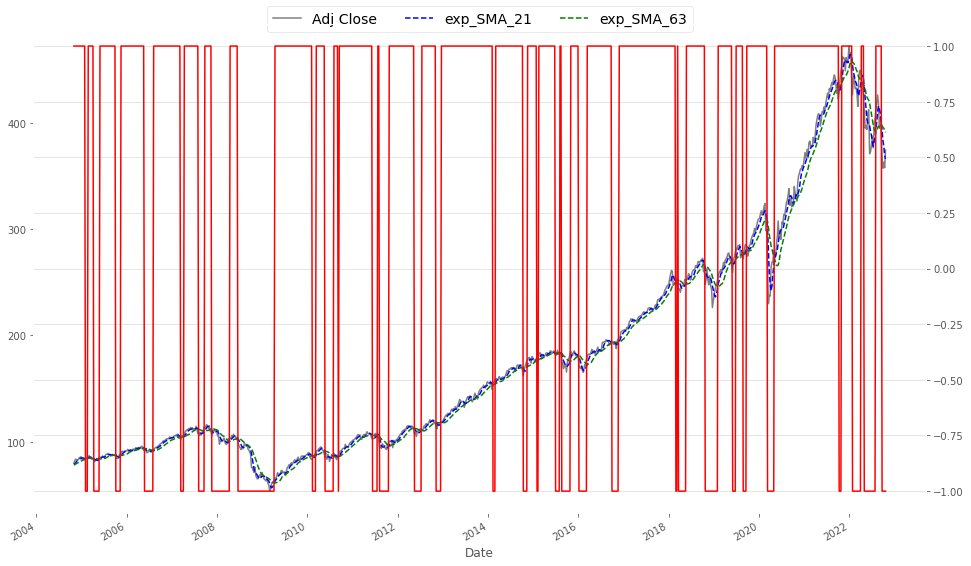

In [39]:
ax = data[["Adj Close",
          "exp_SMA_21",
          "exp_SMA_63",
          "SMA_POS_21_63"]
        ].plot(figsize = (16, 10),
               secondary_y = "SMA_POS_21_63",
               style = ["grey",
                        "b--",
                        "g--",
                        "red"],
              )

ax.legend(loc = "upper center",
          bbox_to_anchor = (0.5, 1.05),
          ncol = 3
          )

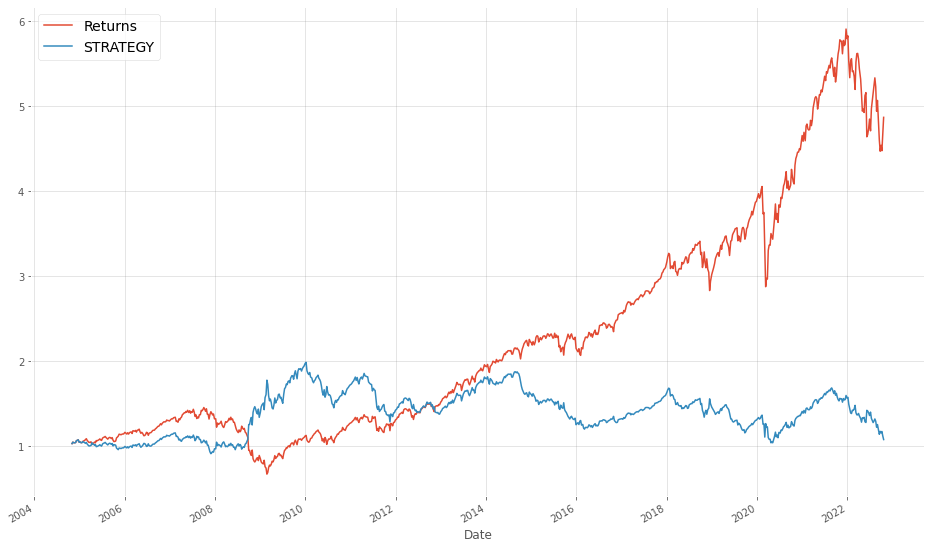

In [40]:
mean_reversion = data.copy()
mean_reversion["STRATEGY"]=mean_reversion["SMA_POS_21_63"]*mean_reversion["Returns"]
mean_reversion["CUMULATIVE_RETURNS"] = mean_reversion["STRATEGY"].cumsum().apply(np.exp)
mean_reversion[["Returns","STRATEGY"]].cumsum().apply(np.exp).plot(figsize = (16, 10))

## [1.4] Model 4: MACD Strategy

In [41]:
MACD = data.copy()
k = MACD["Adj Close"].ewm(span=12, adjust=False, min_periods=12).mean()
d = MACD["Adj Close"].ewm(span=26, adjust=False, min_periods=26).mean()
macd=k-d
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
macd_h = macd - macd_s
MACD['MACD'] = MACD.index.map(macd)
MACD['MACD_H'] = MACD.index.map(macd_h)
MACD['MACD_S'] = MACD.index.map(macd_s)

In [42]:
MACD.dropna(inplace=True)

MACD["POS"] = np.where((MACD["MACD"] > MACD["MACD"].shift(1))&(MACD["MACD"]>MACD["MACD_S"]) , 1 , np.nan)
MACD["POS"] = np.where((MACD["MACD"] < MACD["MACD"].shift(1))&(MACD["MACD"]<MACD["MACD_S"]), -1, MACD["POS"])
MACD["POS"] = np.where(MACD["POS"] * MACD["POS"].shift(1) < 0, 0, MACD["POS"])
MACD["POS"] = MACD["POS"].ffill()
MACD["POS"] = MACD["POS"].fillna(0)

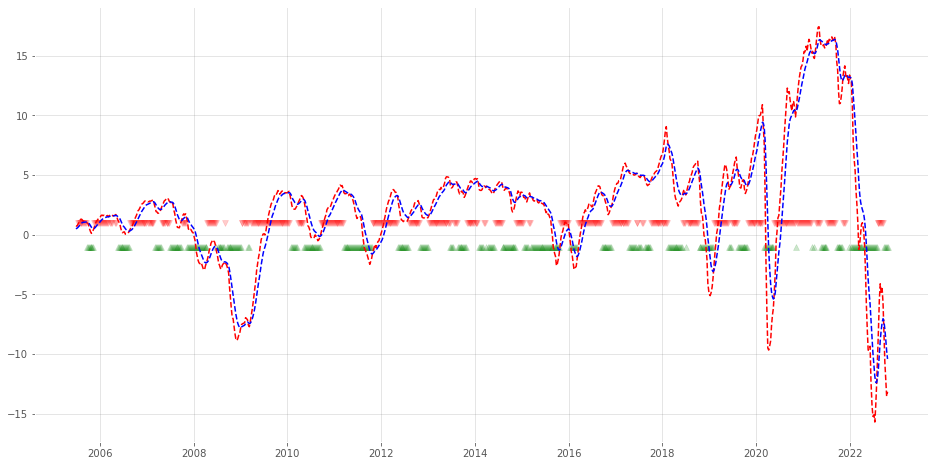

In [43]:
plt.figure(figsize=(16,8))
plt.plot(MACD.dropna().index,MACD["MACD"].dropna(),color = "red", ls = "--")
plt.plot(MACD.dropna().index,MACD["MACD_S"].dropna(),color = "blue", ls = "--")

plt.scatter(MACD[MACD.POS == 1].index, MACD[MACD.POS == 1].POS, color = "r", alpha = 0.20, marker="v")
plt.scatter(MACD[MACD.POS == -1].index, MACD[MACD.POS == -1].POS, color = "g", alpha = 0.20, marker="^")

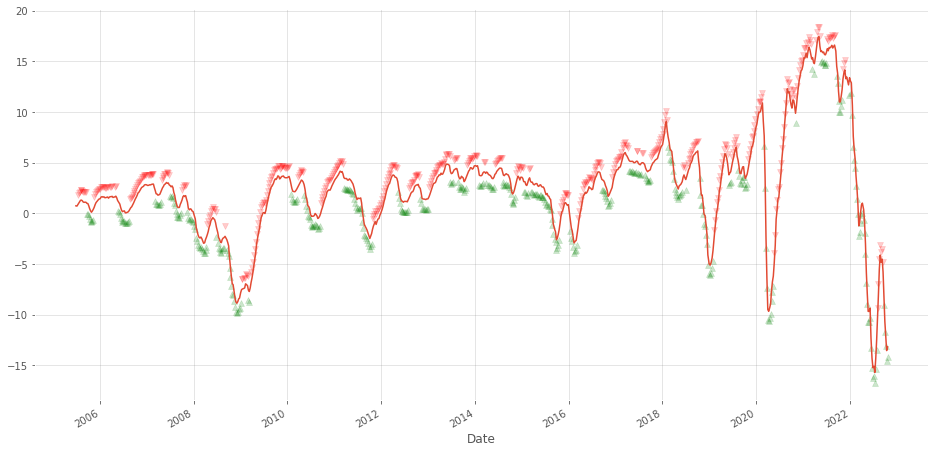

In [44]:
MACD["MACD"].dropna().plot(figsize=(16,8))
plt.scatter(MACD[MACD.POS == 1].index, MACD[MACD.POS == 1].MACD+1, color = "r", alpha = 0.20, marker="v")
plt.scatter(MACD[MACD.POS == -1].index, MACD[MACD.POS == -1].MACD-1, color = "g", alpha = 0.20, marker="^")

In [45]:
MACD["STRATEGY"] = MACD["POS"] * MACD["Returns"]
MACD["CUMULATIVE_RETURNS"] =MACD["STRATEGY"].cumsum().apply(np.exp)

In [46]:
MACD

,Adj Close,Returns,NEW,Direction,EWM_10,EWM_30,EWM_60,EW_VOL_10,EW_VOL_30,EW_VOL_60,...,SMA_CROSSOVER_126_252,SMA_POS_21_63,exp_SMA_21,exp_SMA_63,MACD,MACD_H,MACD_S,POS,STRATEGY,CUMULATIVE_RETURNS
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-28,85.857536,-0.005592,85.378792,0,4.452631,4.447541,4.440940,0.008147,0.014096,0.017725,...,1,1,85.858301,84.214745,0.740511,0.246128,0.494383,0.0,-0.000000,1.000000
2005-07-06,85.378792,0.024390,87.486801,1,4.450417,4.447959,4.442174,0.006146,0.012122,0.016633,...,1,1,85.858146,84.339622,0.714390,0.176006,0.538385,0.0,0.000000,1.000000
2005-07-13,87.486801,0.008216,88.208511,1,4.460493,4.452828,4.445650,0.010488,0.013506,0.017614,...,1,1,86.163672,84.551757,0.853945,0.252448,0.601497,1.0,0.008216,1.008249
2005-07-20,88.208511,0.002831,88.458603,1,4.470238,4.459273,4.450230,0.010391,0.015548,0.019533,...,1,1,86.497881,85.042820,1.011123,0.327701,0.683422,1.0,0.002831,1.011108
2005-07-27,88.458603,0.007485,89.123192,1,4.475984,4.464839,4.454617,0.008135,0.016018,0.020788,...,1,1,87.026340,85.498472,1.142696,0.367419,0.775277,1.0,0.007485,1.018704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,367.950012,-0.029707,357.179993,0,5.947900,5.975732,5.985513,0.031959,0.039342,0.043130,...,-1,-1,392.553865,397.023091,-8.091501,-0.844452,-7.247048,-1.0,0.029707,0.778184
2022-09-30,357.179993,0.015584,362.790009,1,5.913889,5.952985,5.971741,0.035066,0.050037,0.051576,...,-1,-1,383.187635,395.633690,-10.676509,-2.743568,-7.932940,-1.0,-0.015584,0.766150
2022-10-07,362.790009,-0.014325,357.630005,0,5.915030,5.942782,5.963378,0.025406,0.046292,0.051810,...,-1,-1,377.883384,394.608283,-12.132608,-3.359734,-8.772874,-1.0,0.014325,0.777205


# [2] Strategy selections

## [2.1] Best Model: Ensembled Model of XGBoost, Gradient Boosting and KNN

In [47]:
# Portfolio Value
merged["CUMULATIVE_RETURNS_ENSEMBLED"].iloc[-1]*500000

2762969.2788688

In [48]:
# Above market benchmark
(merged["CUMULATIVE_RETURNS_ENSEMBLED"].iloc[-1]-merged["CUMULATIVE_RETURNS_SPY"].iloc[-1])*500000

1882848.9920085964

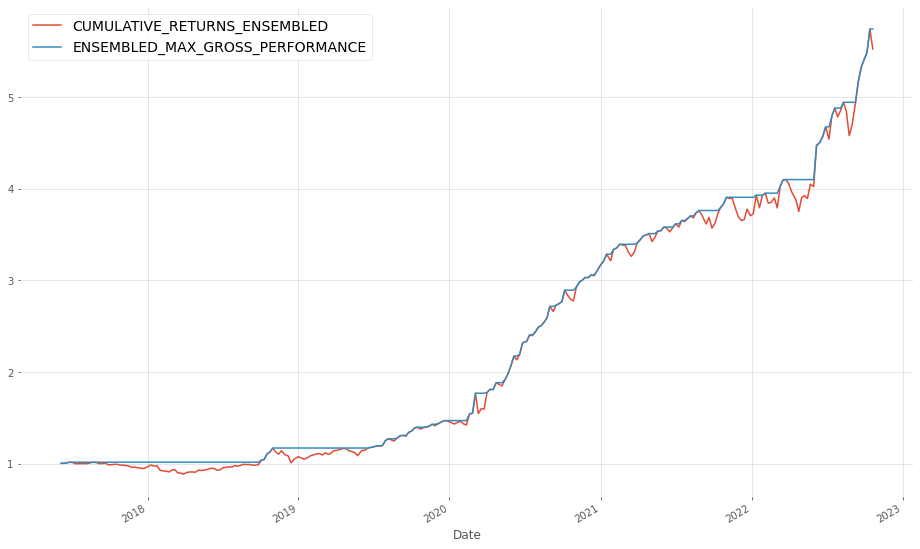

In [49]:
merged["ENSEMBLED_MAX_GROSS_PERFORMANCE"] = merged["CUMULATIVE_RETURNS_ENSEMBLED"].cummax()
merged[["CUMULATIVE_RETURNS_ENSEMBLED","ENSEMBLED_MAX_GROSS_PERFORMANCE"]].dropna().plot(figsize=(16,10))

In [50]:
DRAWDOWN = (merged["ENSEMBLED_MAX_GROSS_PERFORMANCE"] - merged["CUMULATIVE_RETURNS_ENSEMBLED"])/merged["ENSEMBLED_MAX_GROSS_PERFORMANCE"]
DRAWDOWN.max()

0.138444835519786

In [51]:
LONGEST = (DRAWDOWN[DRAWDOWN==0].index[1:].to_pydatetime() - 
          DRAWDOWN[DRAWDOWN==0].index[:-1].to_pydatetime()
          )

LONGEST.max()

datetime.timedelta(days=463)

In [52]:
### Sharpe Ratio
np.sqrt(253)*merged["ENSEMBLED_Strategy"].mean()/merged["ENSEMBLED_Strategy"].std()

3.9235157827523697

In [53]:
### CAGR
(merged["CUMULATIVE_RETURNS_ENSEMBLED"].iloc[-1])**(1/((merged.index[-1].to_pydatetime()-merged.index[1].to_pydatetime()).days/365.25))-1

0.3760423647772646

## [2.2] 2nd Best Model: Mean Reversion

In [54]:
mean_reversion["CUMULATIVE_RETURNS"].iloc[-1]*500000

539734.3190355637

In [55]:
(mean_reversion["CUMULATIVE_RETURNS"].iloc[-1]-mean_reversion["Returns"].cumsum().apply(np.exp).iloc[-1])*500000

-1896037.692569476

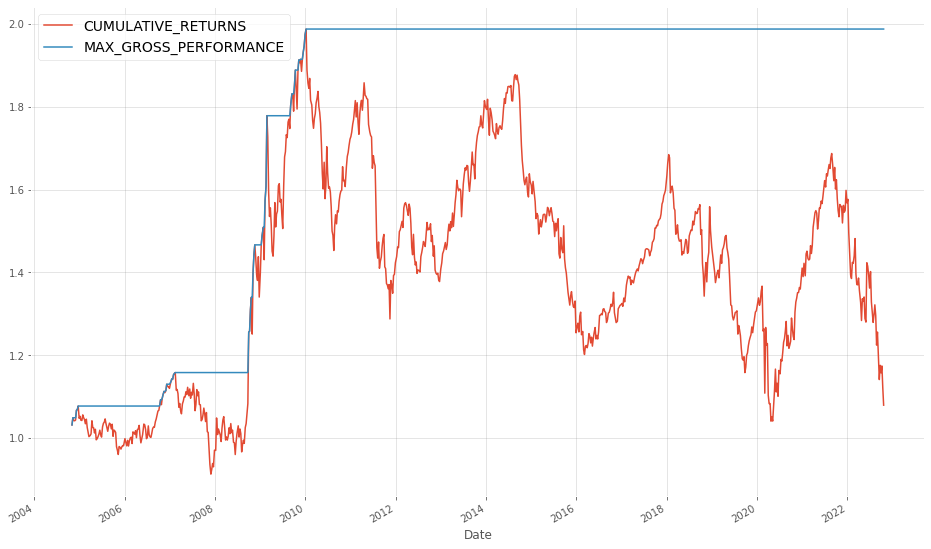

In [56]:
mean_reversion["MAX_GROSS_PERFORMANCE"] = mean_reversion["CUMULATIVE_RETURNS"].cummax()
mean_reversion[["CUMULATIVE_RETURNS","MAX_GROSS_PERFORMANCE"]].dropna().plot(figsize=(16,10))

In [57]:
DRAWDOWN = (mean_reversion["MAX_GROSS_PERFORMANCE"] - mean_reversion["CUMULATIVE_RETURNS"])/mean_reversion["MAX_GROSS_PERFORMANCE"]
DRAWDOWN.max()

0.4763918711538327

In [58]:
LONGEST = (DRAWDOWN[DRAWDOWN==0].index[1:].to_pydatetime() - 
          DRAWDOWN[DRAWDOWN==0].index[:-1].to_pydatetime()
          )

LONGEST.max()

datetime.timedelta(days=659)

In [59]:
### Sharpe Ratio
np.sqrt(253)*mean_reversion["STRATEGY"].mean()/mean_reversion["STRATEGY"].std()

0.057298636470044365

In [60]:
### CAGR
(mean_reversion["CUMULATIVE_RETURNS"].iloc[-1])**(1/((merged.index[-1].to_pydatetime()-merged.index[1].to_pydatetime()).days/365.25))-1

0.014381716282111379

## [2.3] 3rd Best Model: LSTM

In [61]:
Y_df_lstm["LSTM_CUMULATIVE_RETURNS"].iloc[-1]*500000

994000.1756679952

In [62]:
(Y_df_lstm["LSTM_CUMULATIVE_RETURNS"].iloc[-1]-merged["CUMULATIVE_RETURNS_SPY"].iloc[-1])*500000

113879.88880779165

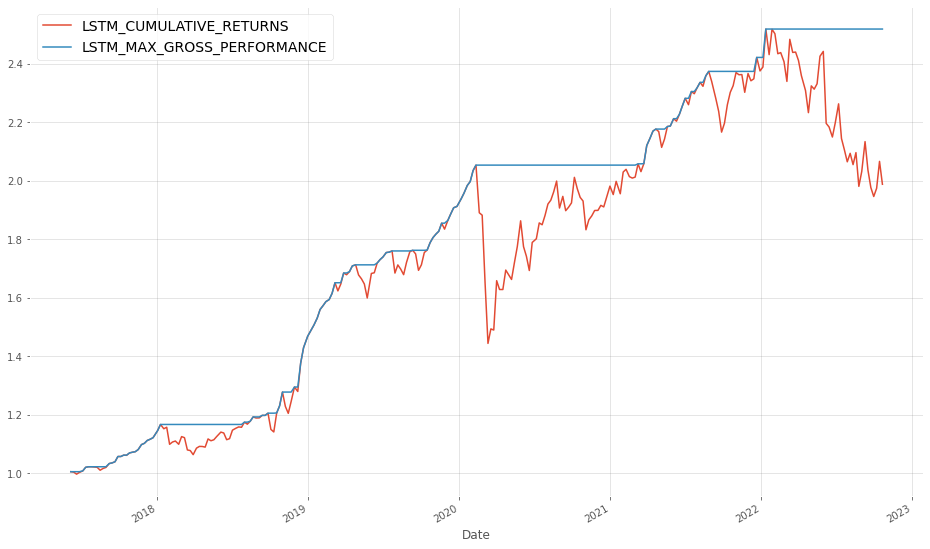

In [63]:
Y_df_lstm["LSTM_MAX_GROSS_PERFORMANCE"] = Y_df_lstm["LSTM_CUMULATIVE_RETURNS"].cummax()
Y_df_lstm[["LSTM_CUMULATIVE_RETURNS","LSTM_MAX_GROSS_PERFORMANCE"]].dropna().plot(figsize=(16,10))

In [64]:
DRAWDOWN = (Y_df_lstm["LSTM_MAX_GROSS_PERFORMANCE"] - Y_df_lstm["LSTM_CUMULATIVE_RETURNS"])/Y_df_lstm["LSTM_MAX_GROSS_PERFORMANCE"]
DRAWDOWN.max()

0.29680749929183275

In [65]:
LONGEST = (DRAWDOWN[DRAWDOWN==0].index[1:].to_pydatetime() - 
          DRAWDOWN[DRAWDOWN==0].index[:-1].to_pydatetime()
          )

LONGEST.max()

datetime.timedelta(days=392)

In [66]:
### Sharpe Ratio
np.sqrt(253)*Y_df_lstm["LSTM_RETURNS"].mean()/Y_df_lstm["LSTM_RETURNS"].std()

1.5382019269268434

In [67]:
### CAGR
(Y_df_lstm["LSTM_CUMULATIVE_RETURNS"].iloc[-1])**(1/((merged.index[-1].to_pydatetime()-merged.index[1].to_pydatetime()).days/365.25))-1

0.1369051628359268

# [3] Executive Summary

## [3.1] Ensembled ML Models

By using various SMA, EWMA, and EW_VOL level, we try to identify whether the market will be trending upwards or downwards at the end of 5 trading days. While some models have better accuracy, the was falsely generated as predicting that market is purely trending upwards will already achieve a good accuracy score or at least 65%. Therefore, another approach was used to identify the better model, by looking at the confusion matrix and choosing models with better split between the binary outcomes. By ensembling the different ML models, we were hoping to reduce variance and improve the overall model performance.

## [3.2] Mean Reversion

Simple Moving Averages to determine direction of markets. More could have been explored by identifying different types of moving averages as well as introducing stop-losses. MACD were also explored but does not have better results compared to SMA models. 

## [3.3] LSTM

LSTM and ARIMA were explored, but we only included LSTM due to shortage of time. Would love to explore LSTM hyperparameter tuning and also using rolling window to build and predict short steps into the future. Although returns were low, we believe that this would turn out to be the best model if sufficient time were provided and the model was tuned properly.

## [3.4] Analysis of Strategies

The ensembeling of Machine Learning models with multiple trading signals crossover showed the best performance. 

By deploying multiple machine learning techniques, it allows us to train and determine the accuracy and taking a final direction of the market, is able to provide a higher confidence of the final trading direction 

As compared to traditional and direct trading indicators, the positions opened are one-sided and direction is bound to the indicator's concept, e.g. the MACD Strategy is traded on convergence and divergence, which directs the poistion of a trade entry.

Lastly, if given sufficient time to implement the strategies we could diversify by adding all top 3 strategy together and hence improve the sharpe and lower the risk. 

## [3.5] Future Improvements 

> Beyond including new features such as S&P 500 components, we can improve on training the models with more hyperparameter tuning and also cosidering other more time lags of S&P 500 or even exploring GARCH model on S&P 500's volatility 

> Machine learning methodology will do better if we can fit in the other source of information like the macroeconomic data such as
    > - VIX 
    > - EFFR
    > - UNRATE
    > - UMCSENT
    > - USDX
> 
> Implement parallel computing when rolling fit and forecast to obtain more trading opportunity in the shortest amount of time.




# [4] Appendix

> This section contains code that or model that could be part of our model preparations and strategy planning. 
> We do not consider these as we have found our best models. 

## [4.1] EMA and SMA Strategy : Entry at in between 5 and 10 ema while SMA points trend direction and MACD Histograms Peak and Troughs 

(4783, 6)
(4783, 7)
Max Drawdown = 0.8089438301362106
Max Drawdown Period = 1193 days, 0:00:00
Sharpe Ratio = 1291.1515792288628
Final PnL : 864765.8715442836
CAGR = 0.02923259749766527
Max Drawdown = 1.0720080499655675
Max Drawdown Period = 1710 days, 0:00:00
Sharpe Ratio = 1299.524863688488
Final PnL : 889243.8950291023
CAGR = 0.030744654892828294


<AxesSubplot:xlabel='Date'>

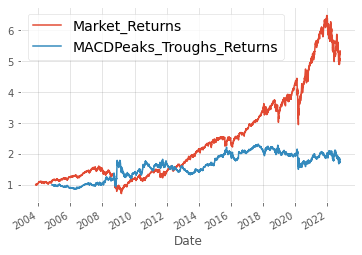

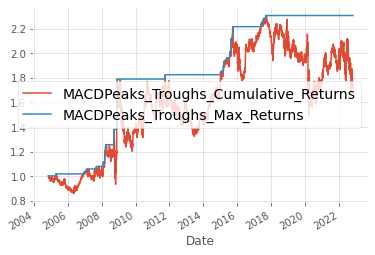

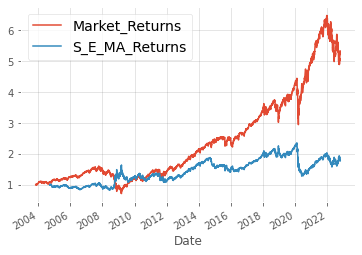

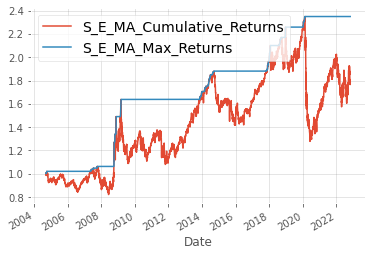

In [3]:
TICKERS = ["SPY"]
x = extract(TICKERS, start=dt.datetime(2003, 11, 1),
            end=dt.datetime(2022, 10, 31))
print(x.shape)

dataset = x.reset_index().set_index('Date')
print(dataset.shape)

dataset["Market_Returns"] = np.log(dataset["Adj Close"] / dataset["Adj Close"].shift(1))

# ==========================EMA5 and EMA 10 and SMA200====================================================

sma200 = dataset.ta.sma(length=200, append=True, close='Adj Close')
ema5 = dataset.ta.ema(length=5, append=True, close='Adj Close')
ema10 = dataset.ta.ema(length=10, append=True, close='Adj Close')


conditions_S_E_MA = [
    (dataset['Adj Close'] < dataset['EMA_5']) & (dataset['EMA_10'] < dataset['Adj Close']) &
    (dataset['Adj Close'] > dataset['SMA_200']),
    (dataset['Adj Close'] > dataset['EMA_5']) & (dataset['EMA_10'] > dataset['Adj Close']) &
    (dataset['Adj Close'] < dataset['SMA_200'])]

choices_S_E_MA = [1, -1]

dataset['S_E_MA_Signal'] = np.select(conditions_S_E_MA, choices_S_E_MA, default=np.nan)
dataset['S_E_MA_Signal'].fillna(method='ffill', inplace=True)
dataset['S_E_MA_Position'] = dataset['S_E_MA_Signal'].shift(1)

dataset['S_E_MA_Returns'] = dataset['S_E_MA_Position'] * dataset["Market_Returns"]
dataset["S_E_MA_Cumulative_Returns"] = dataset["S_E_MA_Returns"].cumsum().apply(np.exp)
dataset['S_E_MA_Max_Returns'] = dataset['S_E_MA_Cumulative_Returns'].cummax()

# ========================MACD Histogram=====================================================
macd = dataset.ta.macd(close="Adj Close",
                       fast=12, slow=26, append=True)

std_multi = 0

positive_hist = dataset[dataset['MACDh_12_26_9'] > 0]['MACDh_12_26_9'].mean() + \
    dataset[dataset['MACDh_12_26_9'] > 0]['MACDh_12_26_9'].std()*std_multi

negative_hist = dataset[dataset['MACDh_12_26_9'] < 0]['MACDh_12_26_9'].mean() - \
    dataset[dataset['MACDh_12_26_9'] < 0]['MACDh_12_26_9'].std()*std_multi

conditions = [dataset["MACDh_12_26_9"] > positive_hist, dataset["MACDh_12_26_9"] < negative_hist]
choices = [-1, 1]
dataset['MACDPeaks_Troughs_Signal'] = np.select(conditions, choices, default=np.nan)
dataset['MACDPeaks_Troughs_Signal'].fillna(method='ffill', inplace=True)
dataset['MACDPeaks_Troughs_Position'] = dataset['MACDPeaks_Troughs_Signal'].shift(1)
dataset['MACDPeaks_Troughs_Returns'] = dataset['MACDPeaks_Troughs_Position'] * dataset["Market_Returns"]
dataset["MACDPeaks_Troughs_Cumulative_Returns"] = dataset["MACDPeaks_Troughs_Returns"].cumsum().apply(np.exp)
dataset['MACDPeaks_Troughs_Max_Returns'] = dataset['MACDPeaks_Troughs_Cumulative_Returns'].cummax()

## MACD Peak and Troughs Performance
DRAWDOWN = dataset["MACDPeaks_Troughs_Max_Returns"] - dataset["MACDPeaks_Troughs_Cumulative_Returns"]
print(f'Max Drawdown = {DRAWDOWN.max()}')

PERIOD = (DRAWDOWN[DRAWDOWN == 0].index[1:].to_pydatetime() - 
          DRAWDOWN[DRAWDOWN == 0].index[:-1].to_pydatetime()
          )

print(f'Max Drawdown Period = {PERIOD.max()}')

### Sharpe Ratio
sharpe = np.sqrt(253)*dataset["MACDPeaks_Troughs_Returns"].apply(np.exp).mean()/dataset["MACDPeaks_Troughs_Returns"].apply(np.exp).std()

print(f'Sharpe Ratio = {sharpe}')



#### capital final
final_MR =500_000*dataset["MACDPeaks_Troughs_Cumulative_Returns"][-1]
print(f'Final PnL : {final_MR}')


#### CAGR

D_MR = (dataset.index[-1] - dataset.index[0]).days

CAGR_MR = ((final_MR / 500_000) ** (365.0/D_MR)) - 1

print(f'CAGR = {CAGR_MR}')

dataset[["Market_Returns", "MACDPeaks_Troughs_Returns"]].cumsum().apply(np.exp).plot()

dataset[["MACDPeaks_Troughs_Cumulative_Returns", "MACDPeaks_Troughs_Max_Returns"]
        ].dropna().plot()
# EMA5 and EMA10 and SMA 200 Performance
DRAWDOWN = dataset["S_E_MA_Max_Returns"] - dataset["S_E_MA_Cumulative_Returns"]
print(f'Max Drawdown = {DRAWDOWN.max()}')

PERIOD = (DRAWDOWN[DRAWDOWN == 0].index[1:].to_pydatetime() - 
          DRAWDOWN[DRAWDOWN == 0].index[:-1].to_pydatetime()
          )

print(f'Max Drawdown Period = {PERIOD.max()}')

### Sharpe Ratio
sharpe = np.sqrt(253)*dataset["S_E_MA_Returns"].apply(np.exp).mean()/dataset["S_E_MA_Returns"].apply(np.exp).std()

print(f'Sharpe Ratio = {sharpe}')



#### capital final
final_MR =500_000*dataset["S_E_MA_Cumulative_Returns"][-1]
print(f'Final PnL : {final_MR}')


#### CAGR

D_MR = (dataset.index[-1] - dataset.index[0]).days

CAGR_MR = ((final_MR / 500_000) ** (365.0/D_MR)) - 1

print(f'CAGR = {CAGR_MR}')

dataset[["Market_Returns", "S_E_MA_Returns"]].cumsum().apply(np.exp).plot()

dataset[["S_E_MA_Cumulative_Returns", "S_E_MA_Max_Returns"]
        ].dropna().plot()

## [4.2] Forward Walk Implementation with arima model 

The forward walk implementation could be used for various of other ML models and continuously improve the models in production environment.

However due to the issue arises from different models during this kind of fitting we are unable to do it for the rest of the models that provided us our best outcome.

In [10]:
# fill missing dates
idx = pd.date_range(Y.index.min(), Y.index.max())
X_fw = X.reindex(idx, method='ffill')
X_fw.index.name = 'Date'

Y_fw = Y.reindex(idx, method='ffill')
Y_fw.index.name = 'Date'

# implementing walk forward fit and predict to increase accuracy 
fw_size = int(len(X_fw) * 0.3)
n_train = fw_size
n_test = len(X_fw) - n_train
n_records = len(X_fw)
fit_window = 30 

Y_TEST_FULL = Y_fw[n_train:]
prediction =  Y_TEST_FULL.copy()
train_end = Y_TEST_FULL.index[0]

X_train_fw_ini, X_test_fw_ini = X_fw[:train_end], X_fw[train_end:train_end+timedelta(days=1)]
Y_train_fw_ini, Y_test_fw_ini = Y_fw[:train_end], Y_fw[train_end:train_end+timedelta(days=1)]

In [11]:
# initial prediction of the first data out of training 
y_hat = get_auto_arima_pred(X_train_fw_ini, X_test_fw_ini, Y_train_fw_ini, Y_test_fw_ini)
prediction.iloc[0] = y_hat[0]


In [ ]:

Y_TEST_FULL = Y_TEST_FULL.iloc[1:] # first row already predicted 
train_end = Y_TEST_FULL.index[0]

for train_end in Y_TEST_FULL.index:
    x_train_window = X_fw[train_end-timedelta(days=fit_window):train_end-timedelta(days=1)]
    x_test_window = X_fw[train_end-timedelta(days=0):train_end]  # work around to slice only 1 day
    y_train_window = Y_fw[train_end-timedelta(days=fit_window):train_end-timedelta(days=1)]
    y_test_window = Y_fw[train_end-timedelta(days=0):train_end]
    # TODO: try to change to implement for other ML models in the future 
    y_hat_tmp = get_auto_arima_pred(x_train_window, x_test_window, y_train_window, y_test_window)
    prediction[train_end] = y_hat_tmp[0]

# back up rolling fit outcome 
prediction.to_pickle('data/forwardWalkPred_arima.pkl')

## [4.3] Mean reversion with SD band

<AxesSubplot:xlabel='Date'>

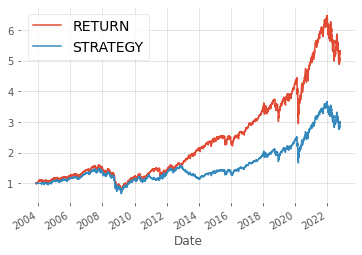

In [14]:
MR2 = SPY.copy()
MR2['RETURN'] = np.log(MR2['Adj Close']/MR2['Adj Close'].shift(1))
MR2['SMA_21'] = MR2['Adj Close'].rolling(window=21).mean()
MR2['SD'] = MR2['Adj Close'].rolling(window=21).std()
MR2["+3SD"] = MR2["SMA_21"]+3*MR2["SD"]
MR2["-3SD"] = MR2["SMA_21"]-3*MR2["SD"]

MR2["POS"] = np.where(MR2["Adj Close"] > MR2["+3SD"], -1, np.nan)

MR2["POS"] = np.where(MR2["Adj Close"] < MR2["-3SD"], 1, MR2["POS"])

MR2["POS"] = MR2["POS"].ffill()
MR2["POS"] = MR2["POS"].fillna(0)

MR2["STRATEGY"] = MR2["POS"].shift(1) * MR2["RETURN"]
MR2[["RETURN", "STRATEGY"]].dropna().cumsum().apply(np.exp).plot()


# [5] Contribution Summary



### [5.1] Teo Jia Qing: 

I have built the Ensembled ML Models, mean reversion and MACD, and modeled the LSTM model with Hong Yun. In addition to producing the strategy returns, sharpe ratio, CAGR and drawdown graphs for all the models, I have also written the executive summary.


### [5.2] Hong Yun:

- Implemented forward walking on arima model to see if make sure that the rest of the ML strategy can be fitted this way. This ensure that the model will be updated against different market regime 
- Auto arima giving issue when implementing rolling fit and forecast dues to small training size
- Tried to tune LSTM model but encounter alot of issues such as LSTM will condenses output which resulted in Y_hat len to be smaller than Y_test len.
- Tidy up the working sheet

### [5.3] Jeriel: 

Build trend trading strategies, where the entry is in between EMA 5 and EMA 10 , and SMA 200 as the direction to buy or sell. Further explored peaks and troughs of MACD-Histogram, selling at peak of Histogram and buying at troughs of Histogram

### [5.4] Gangru:

Mean reversion with SD band